# Students Clustering Based on Grades

## Loading The dataset and slecting features

### Pyspark Initialiasing

In [1]:
# to make pyspark importable as a regular library
import findspark
findspark.init()

import pyspark

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession \
       .builder.config("spark.jars", "/usr/share/java/mysql-connector-java-8.0.28.jar")\
       .master("local").appName("PySpark app")\
       .getOrCreate()

22/06/26 18:20:59 WARN Utils: Your hostname, DESKTOP-CRQMAJP resolves to a loopback address: 127.0.1.1; using 172.23.22.169 instead (on interface eth0)
22/06/26 18:20:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/06/26 18:21:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Load Libraries

In [2]:
# Data Frame spark profiling 
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array


# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

### Load Data to Spark DataFrame

In [4]:
#Initializing File Type
import mysql.connector
import getpass

print("Enter password:")
password = getpass.getpass()
table = 'mdl_grade_grades_history'

def load_data(table):
    df = spark.read \
         .format("jdbc") \
         .option("url", "jdbc:mysql://localhost:3306/moodle") \
         .option("driver", "com.mysql.cj.jdbc.Driver") \
         .option("dbtable", table) \
         .option("user", "wsl_root") \
         .option("password", password) \
         .load()
    return df

Enter password:


 ········


In [5]:
df = load_data(table)

In [6]:
help(load_data)

Help on function load_data in module __main__:

load_data(table)



 Check Data

In [7]:
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
#show 5 observation in DataFrame
df.show(5)

+------+------+------+--------+------------+----------+------+------+--------+-----------+-----------+----------+------------+----------+------+------+--------+--------+----------+--------+--------+--------------+-----------+-----------------+
|    id|action| oldid|  source|timemodified|loggeduser|itemid|userid|rawgrade|rawgrademax|rawgrademin|rawscaleid|usermodified|finalgrade|hidden|locked|locktime|exported|overridden|excluded|feedback|feedbackformat|information|informationformat|
+------+------+------+--------+------------+----------+------+------+--------+-----------+-----------+----------+------------+----------+------+------+--------+--------+----------+--------+--------+--------------+-----------+-----------------+
|221372|     1|107173|mod/quiz|  1468487749|         2| 20565|     3|    null|   10.00000|    0.00000|      null|           3|      null|     0|     0|       0|       0|         0|       0|    null|             0|       null|                0|
|221389|     1|107189|mo

In [9]:
#Print Schema
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- action: long (nullable = true)
 |-- oldid: long (nullable = true)
 |-- source: string (nullable = true)
 |-- timemodified: long (nullable = true)
 |-- loggeduser: long (nullable = true)
 |-- itemid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- rawgrade: decimal(10,5) (nullable = true)
 |-- rawgrademax: decimal(10,5) (nullable = true)
 |-- rawgrademin: decimal(10,5) (nullable = true)
 |-- rawscaleid: long (nullable = true)
 |-- usermodified: long (nullable = true)
 |-- finalgrade: decimal(10,5) (nullable = true)
 |-- hidden: long (nullable = true)
 |-- locked: long (nullable = true)
 |-- locktime: long (nullable = true)
 |-- exported: long (nullable = true)
 |-- overridden: long (nullable = true)
 |-- excluded: long (nullable = true)
 |-- feedback: string (nullable = true)
 |-- feedbackformat: long (nullable = true)
 |-- information: string (nullable = true)
 |-- informationformat: long (nullable = true)



In [10]:
len(df.columns), df.columns

(24,
 ['id',
  'action',
  'oldid',
  'source',
  'timemodified',
  'loggeduser',
  'itemid',
  'userid',
  'rawgrade',
  'rawgrademax',
  'rawgrademin',
  'rawscaleid',
  'usermodified',
  'finalgrade',
  'hidden',
  'locked',
  'locktime',
  'exported',
  'overridden',
  'excluded',
  'feedback',
  'feedbackformat',
  'information',
  'informationformat'])

In [11]:
df = df.drop('rawgrademax','rawgrademin','rawgrade','action','oldid','loggeduser','usermodified','timemodified','rawscaleid', 'hidden',	'locked',	'locktime',	'exported',	'overridden',	'excluded',	'feedback',	'feedbackformat', 'information',	'informationformat')

In [12]:
#Categorical and numerical variable
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] #just will select string data type
print("cat_cols:", cat_cols)
num_cols = [item[0] for item in df.dtypes if item[1].startswith('big') | item[1].startswith('decimal')] #just will select integer or double data type
print("num_cols:", num_cols)

cat_cols: ['source']
num_cols: ['id', 'itemid', 'userid', 'finalgrade']


In [13]:
#count number of observation
df.count()

8692

In [14]:
# Check summary statistic of numerical columns

df.select(num_cols).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|                id|            itemid|            userid|        finalgrade|
+-------+------------------+------------------+------------------+------------------+
|  count|              8692|              8692|              8692|              8659|
|   mean| 283417.6446157386|20565.634031293142|27380.096065347447|      14.362166532|
| stddev|32297.881991362443|  4.43974027389419|18542.800409869284|20.917569814142563|
|    min|            221372|             20560|                 3|           0.00000|
|    max|            314561|             20576|             43624|         100.00000|
+-------+------------------+------------------+------------------+------------------+



### Check Missing Value:
We are using two metode to check missing values:

    1.Using pandas dataframe
    2.Using pyspark dataframe

In [15]:
#convert to pandas DataFrame
df_pd=df.toPandas()

In [16]:
df_pd

,id,source,itemid,userid,finalgrade
0,221372,mod/quiz,20565,3,None
1,221389,mod/quiz,20560,39808,9.00000
2,221405,mod/quiz,20560,41751,8.00000
3,221421,mod/quiz,20560,41751,10.00000
4,221422,mod/quiz,20560,37384,8.00000
...,...,...,...,...,...
8687,314546,mod/data,20564,39319,5.00000
8688,314547,mod/data,20564,39319,4.00000
8689,314557,mod/quiz,20571,40620,6.00000
8690,314559,mod/quiz,20571,40620,7.00000


In [17]:
def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [18]:
missing_values_table(df_pd)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
source,352,4.0
finalgrade,33,0.4


In [19]:
#Check Missing Value in Pyspark Dataframe
def count_nulls(df_final):
    """Input pyspark dataframe and return list of columns with missing value and it's total value"""
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, ex ('C0', 'bigint')
        cname = col[0]        #splits out the column name, ex 'C0'    
        ctype = col[1]        #splits out the column type, ex 'bigint'
        nulls = df.where( df[cname].isNull() ).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [20]:
null_counts = count_nulls(df)
null_counts

[('source', 352), ('finalgrade', 33)]

In [21]:
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

['source', 'finalgrade']

In [22]:
#Create dataframe which just has list_cols_miss
df_miss= df.select(*list_cols_miss)
df_miss.dtypes

[('source', 'string'), ('finalgrade', 'decimal(10,5)')]

In [23]:
#Define categorical columns and numerical columns which have missing value.
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('big') | item[1].startswith('decimal')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)

catcolums_miss: ['source']
numcolumns_miss: ['finalgrade']


In [24]:
#Handle Missing Values
#Drop missing value
df_Nomiss=df.na.drop()

In [25]:
df_Nomiss

DataFrame[id: bigint, source: string, itemid: bigint, userid: bigint, finalgrade: decimal(10,5)]

In [26]:
#fill missing value in categorical variable with most frequent
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] #group by based on categories and count each categories and sort descending then take the first value in column
    print(x, mode) #print name of columns and it's most categories 
    df = df.na.fill({x:mode}) #fill missing value in each columns with most frequent

source mod/quiz


In [27]:
#fill missing value in numerical variable with average
for i in numcolumns_miss:
    meanvalue = df.select(round(mean(i),5)).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue) #print name of columns and it's average value
    df=df.na.fill({i:int(meanvalue)}) #fill missing value in each columns with it's average value

finalgrade 14.36217


In [28]:
#Check Missing value after filling
null_counts = count_nulls(df)
null_counts

[]

# EDA
## convert spark dataframe to pandas for visualization

In [29]:
df_pd2=df.toPandas()

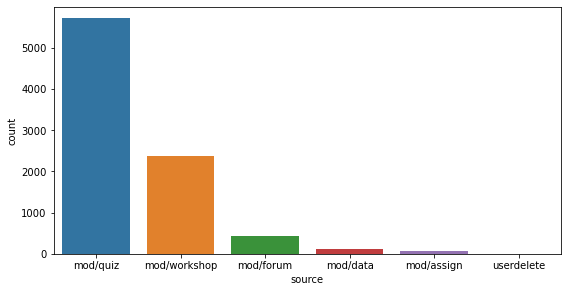

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='source', data=df_pd2, order=df_pd['source'].value_counts().index)
plt.show()

/home/abdelilah/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


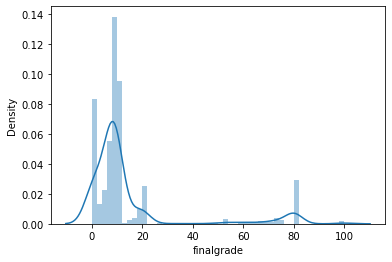

In [31]:
#density plot finalgrade
sns.distplot(df_pd2['finalgrade'])
plt.show()


/home/abdelilah/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


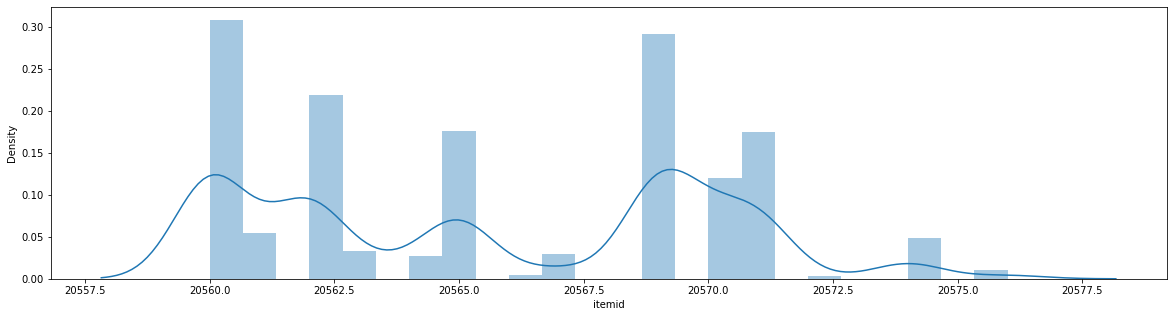

In [32]:
#density plot itemid 
plt.figure(figsize=(20,5))
sns.distplot(df_pd2['itemid'])
plt.show()

## Check outlier

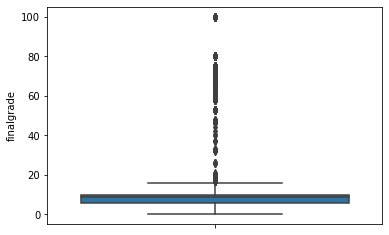

In [33]:
#Check outlier in numerical variable: 'source'
df_pd2.finalgrade = df_pd2.finalgrade.astype(float)
sns.boxplot(y='finalgrade',data=df_pd2)
plt.show()

## Handle of outlier

Outlier is observations that fall below lower side or above upper side.

To handle outlier we approach by replacing the value greater than upper side with upper side value and also replacing the value lower than lower side with lower side value. So, we need calculate upper and lower side from quantile value, quantile is probability distribution of variable. In General, there are three quantile:

Q1 = the value that cut off 25% of the first data when it is sorted in ascending order.
Q2 = cut off data, or median, it's 50 % of the data
Q3 = the value that cut off 75% of the first data when it is sorted in ascending order.
IQR or interquartile range is range between Q1 and Q3. IQR = Q3 - Q1.

Upper side = Q3 + 1.5 * IQR

Lower side = Q1 - 1.5 * IQR

In [34]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)),
                               ['percentile']+num_cols) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant

In [35]:
quantile=quantile(df)

In [36]:
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper

In [37]:
def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower

### Replacing outlier

In [38]:
def replace_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d

In [39]:
def replace_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

In [40]:
#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols:
    lower=lower_value(quantile,i)
    df=replace_outlier_low2(df, i, lower)

In [42]:
#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols:
    upper=upper_value(quantile,x)
    df=replace_outlier_up2(df, x, upper)

In [43]:
type(df)

pyspark.sql.dataframe.DataFrame

### Check distribution after replacing outlier

In [74]:
df.select('finalgrade').describe().show()

+-------+-----------------+
|summary|       finalgrade|
+-------+-----------------+
|  count|             8692|
|   mean|8.269443166129774|
| stddev|4.873535456233215|
|    min|              0.0|
|    max|             16.0|
+-------+-----------------+



In [45]:
df_pd3=df.toPandas()

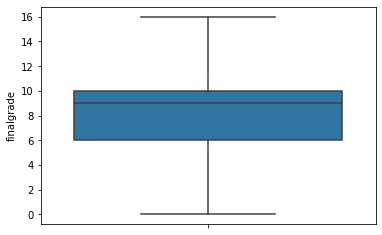

In [46]:
#Check outlier in numerical variable: 'AnnIncome'
sns.boxplot(y="finalgrade",data=df_pd3)
plt.show()

/home/abdelilah/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


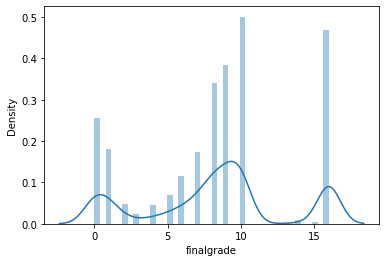

In [47]:
#density plot finalgrade
sns.distplot(df_pd3['finalgrade'])
plt.show()

## Feature Engineering

##### Before splitting the data train, all categorical variables must be made numerical. There are several approaches to categorical variables in SparkML, including:

##### 1. StringIndexer, which is to encode the string label into the index label by sequencing the string frequency descending and giving the smallest index (0) at most string frequency.
##### 2. One-hot Encoding, which is mapping the label column (string label) on the binary column.
##### 3. Vector assembler, which is mapping all columns in vector.

In [48]:
df.printSchema()

root
 |-- id: double (nullable = true)
 |-- source: string (nullable = false)
 |-- itemid: double (nullable = true)
 |-- userid: double (nullable = true)
 |-- finalgrade: double (nullable = true)



In [49]:
# define columns name for string indexer and one hot encoder processing
cat_columns_string_vec = []
for c in cat_cols:
    cat_columns_string= c+"_vec"
    cat_columns_string_vec.append(cat_columns_string)

cat_columns_string_vec

['source_vec']

In [50]:
#create index for categorical variables with stringIndexer   
stringIndexer = [StringIndexer(inputCol=x, outputCol=x+"_Index")
                  for x in cat_cols]
#use oneHotEncoder to convert categorical variable to binary
encoder = [OneHotEncoder(inputCol=x+"_Index", outputCol=y)
           for x,y in zip(cat_cols, cat_columns_string_vec)]
tmp = [[i,j] for i,j in zip(stringIndexer, encoder)]
tmp = [i for sublist in tmp for i in sublist]

In [51]:
#define columns for vector assembler processing
cols_assember=num_cols + cat_columns_string_vec
cols_assember

['id', 'itemid', 'userid', 'finalgrade', 'source_vec']

In [52]:
#create vector assembler from cols_assember
assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')
tmp += [assembler]

#create pipeline for stringIndexer, oneHotEncoder and vectorassembler
pipeline=Pipeline(stages=tmp)

In [53]:
#fit and transform pipeline to dataframe
df_final = pipeline.fit(df).transform(df)

In [54]:
df_final.show(4)

+--------+--------+-------+-------+----------+------------+-------------+--------------------+
|      id|  source| itemid| userid|finalgrade|source_Index|   source_vec|            features|
+--------+--------+-------+-------+----------+------------+-------------+--------------------+
|221372.0|mod/quiz|20565.0|    3.0|      14.0|         0.0|(5,[0],[1.0])|[221372.0,20565.0...|
|221389.0|mod/quiz|20560.0|39808.0|       9.0|         0.0|(5,[0],[1.0])|[221389.0,20560.0...|
|221405.0|mod/quiz|20560.0|41751.0|       8.0|         0.0|(5,[0],[1.0])|[221405.0,20560.0...|
|221421.0|mod/quiz|20560.0|41751.0|      10.0|         0.0|(5,[0],[1.0])|[221421.0,20560.0...|
+--------+--------+-------+-------+----------+------------+-------------+--------------------+
only showing top 4 rows



In [55]:
#create model scaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [56]:
#Compute ScalerModel by fitting the StandardScaler
scalerModel = scaler.fit(df_final)

In [57]:
# Normalize each features to have unit standard deviation.
cluster_final_data = scalerModel.transform(df_final).select('Id', 'scaledFeatures')
cluster_final_data.show()

+--------+--------------------+
|      Id|      scaledFeatures|
+--------+--------------------+
|221372.0|[6.85407173322394...|
|221389.0|[6.85459808352779...|
|221405.0|[6.85509347204907...|
|221421.0|[6.85558886057034...|
|221422.0|[6.85561982235292...|
|221438.0|[6.85611521087420...|
|221439.0|[6.85614617265678...|
|221455.0|[6.85664156117805...|
|221456.0|[6.85667252296063...|
|221457.0|[6.85670348474321...|
|221473.0|[6.85719887326448...|
|221489.0|[6.85769426178576...|
|221505.0|[6.85818965030703...|
|221521.0|[6.85868503882831...|
|221537.0|[6.85918042734958...|
|221538.0|[6.85921138913216...|
|221554.0|[6.85970677765344...|
|221570.0|[6.86020216617471...|
|221586.0|[6.86069755469599...|
|221602.0|[6.86119294321726...|
+--------+--------------------+
only showing top 20 rows



## Modelling K-Mean


#### Optimize choice of k

In [58]:
from pyspark.ml.evaluation import ClusteringEvaluator
#Compute cost function
cost= np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_final)
    cost[k] = model.summary.trainingCost
    #predictions = model.transform(df_final)
    #evaluator = ClusteringEvaluator()
    #cost[k] = evaluator.evaluate(predictions)

22/06/26 18:30:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/26 18:30:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [59]:
cost

array([0.00000000e+00, 0.00000000e+00, 2.96801638e+12, 7.13470282e+11,
       5.87712001e+11, 4.54373679e+11, 3.42003359e+11, 3.18103757e+11,
       2.21515136e+11, 1.86635717e+11, 1.70052314e+11, 1.64480471e+11,
       1.49684963e+11, 1.35580409e+11, 1.19701730e+11, 1.04318907e+11,
       1.10963578e+11, 1.03630975e+11, 8.18895741e+10, 8.09568053e+10])

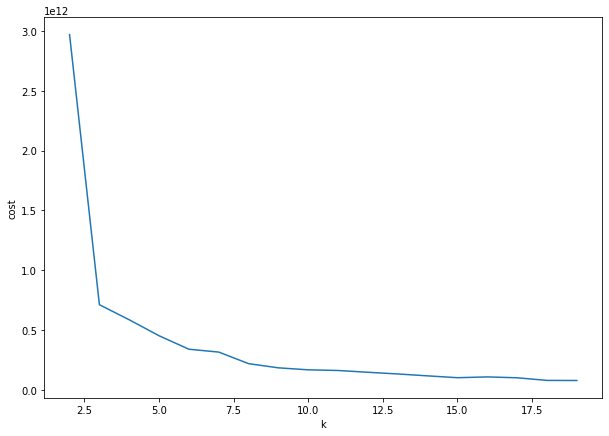

In [60]:
#Plot the cost
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

In [61]:
#Create model KMeans with K=5
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_final)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.04432957e+05 2.05667525e+04 3.97064090e+04 7.69781830e+00
 8.96776294e-01 0.00000000e+00 6.41484858e-02 2.99576685e-02
 7.81504396e-03]
[3.07789013e+05 2.05692865e+04 3.80212709e+02 1.01149163e+01
 7.53424658e-02 9.07153729e-01 5.70776256e-03 0.00000000e+00
 1.17960426e-02]
[2.42184995e+05 2.05616983e+04 4.02113599e+04 7.86453488e+00
 9.29069767e-01 0.00000000e+00 5.81395349e-02 1.10465116e-02
 1.74418605e-03]
[2.72201821e+05 2.05626046e+04 3.63194449e+04 2.11406844e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[2.29243328e+05 2.05602208e+04 3.59749119e+04 7.49801980e+00
 8.90099010e-01 0.00000000e+00 1.08910891e-01 0.00000000e+00
 9.90099010e-04]


In [62]:
#transfrom model to dataset
test=model.transform(df_final)

In [63]:
type(test)

pyspark.sql.dataframe.DataFrame

In [64]:
test.show(4)

+--------+--------+-------+-------+----------+------------+-------------+--------------------+----------+
|      id|  source| itemid| userid|finalgrade|source_Index|   source_vec|            features|prediction|
+--------+--------+-------+-------+----------+------------+-------------+--------------------+----------+
|221372.0|mod/quiz|20565.0|    3.0|      14.0|         0.0|(5,[0],[1.0])|[221372.0,20565.0...|         4|
|221389.0|mod/quiz|20560.0|39808.0|       9.0|         0.0|(5,[0],[1.0])|[221389.0,20560.0...|         4|
|221405.0|mod/quiz|20560.0|41751.0|       8.0|         0.0|(5,[0],[1.0])|[221405.0,20560.0...|         4|
|221421.0|mod/quiz|20560.0|41751.0|      10.0|         0.0|(5,[0],[1.0])|[221421.0,20560.0...|         4|
+--------+--------+-------+-------+----------+------------+-------------+--------------------+----------+
only showing top 4 rows



In [65]:
#Assign cluster to the event in data
prediction= model.transform(df_final).select(*num_cols,*cat_cols, 'prediction').collect()

#create dataframe 
prediction=spark.createDataFrame(prediction)

In [82]:
prediction.show()

+--------+-------+-------+----------+--------+----------+
|      id| itemid| userid|finalgrade|  source|prediction|
+--------+-------+-------+----------+--------+----------+
|221372.0|20565.0|    3.0|      14.0|mod/quiz|         4|
|221389.0|20560.0|39808.0|       9.0|mod/quiz|         4|
|221405.0|20560.0|41751.0|       8.0|mod/quiz|         4|
|221421.0|20560.0|41751.0|      10.0|mod/quiz|         4|
|221422.0|20560.0|37384.0|       8.0|mod/quiz|         4|
|221438.0|20560.0|37384.0|      10.0|mod/quiz|         4|
|221439.0|20560.0| 4977.0|       6.0|mod/quiz|         4|
|221455.0|20560.0| 4977.0|       8.0|mod/quiz|         4|
|221456.0|20560.0| 4977.0|      10.0|mod/quiz|         4|
|221457.0|20560.0|39304.0|      10.0|mod/quiz|         4|
|221473.0|20560.0|41618.0|       9.0|mod/quiz|         4|
|221489.0|20560.0|41885.0|       8.0|mod/quiz|         4|
|221505.0|20560.0|39904.0|       7.0|mod/quiz|         4|
|221521.0|20560.0|39901.0|       9.0|mod/quiz|         4|
|221537.0|2056

In [67]:
#grouping by our prediction of cluster
prediction.groupBy('prediction').count().sort(col('prediction')).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 3071|
|         1| 2628|
|         2| 1720|
|         3|  263|
|         4| 1010|
+----------+-----+



In [81]:
#grouping by cluster prediction and check average of finalgrade
prediction.groupBy('prediction').agg({'finalgrade':'mean'}).show()

+----------+------------------+
|prediction|   avg(finalgrade)|
+----------+------------------+
|         0| 7.697818300227939|
|         1|10.114916286149162|
|         3|2.1140684410646386|
|         2|  7.86453488372093|
|         4| 7.498019801980198|
+----------+------------------+



### Visualize the result
To create the visualization, convert the result dataframe spark to pandas dataframe. We will create 3D visualization from itemid, userid and finalgrade as predictor.

In [69]:
#convert prediction to Pandas
pred_pd=prediction.toPandas().set_index('id')

In [70]:
#show pandas dataframe
pred_pd.head(5)

,itemid,userid,finalgrade,source,prediction
id,,,,,
221372.0,20565.0,3.0,14.0,mod/quiz,4
221389.0,20560.0,39808.0,9.0,mod/quiz,4
221405.0,20560.0,41751.0,8.0,mod/quiz,4
221421.0,20560.0,41751.0,10.0,mod/quiz,4
221422.0,20560.0,37384.0,8.0,mod/quiz,4


In [71]:
prediction.groupBy('source').count().show()

+------------+-----+
|      source|count|
+------------+-----+
|mod/workshop| 2384|
|    mod/quiz| 5712|
|  mod/assign|   59|
|    mod/data|  111|
|  userdelete|    4|
|   mod/forum|  422|
+------------+-----+



/tmp/ipykernel_729/488489610.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,20)).gca(projection='3d')


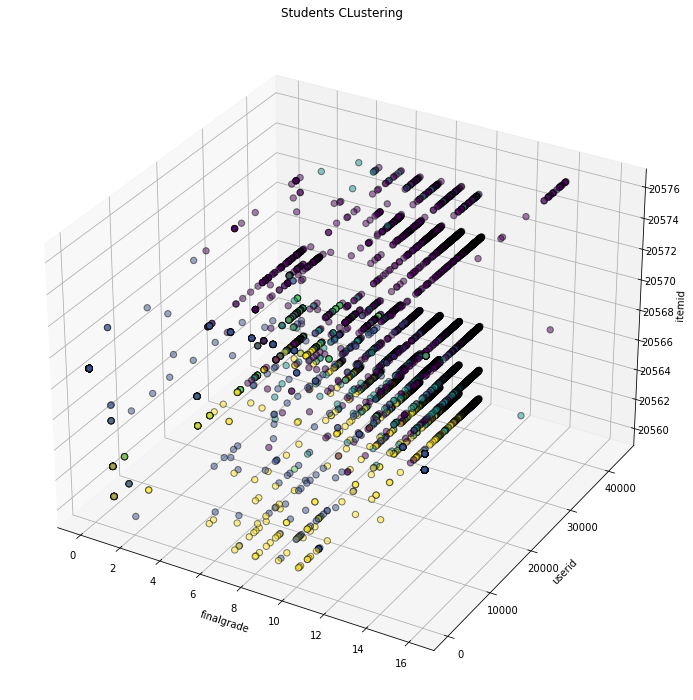

In [103]:
from mpl_toolkits.mplot3d import Axes3D
#Create 3d visualization
threedee = plt.figure(figsize=(12,20)).gca(projection='3d')
threedee.scatter(pred_pd.finalgrade.astype(float), pred_pd.userid.astype(float), pred_pd.itemid.astype(float), c=pred_pd.prediction, cmap = 'viridis', edgecolor='k', s=40, alpha = 0.5)
threedee.set_title('Students CLustering')
threedee.set_xlabel('finalgrade')
threedee.set_ylabel('userid')
threedee.set_zlabel('itemid')
plt.show()

In [94]:
spark